In [1]:
%matplotlib inline

import sys
import datetime
import random
import math
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("darkgrid")

PANEL_SCORE = True
features = {}

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import imp
imp.reload(ut)

<module 'utils.utils' from '/home/condauser/notebooks/utils/utils.py'>

In [3]:
tar = ql.load_target()
tar = ut.xs_winsorize(tar)
tar.ix['1996-05-31'] = np.nan
tar.ix['1996-06-30'] = np.nan
tar.ix['1998-05-31'] = np.nan
tar.ix['1998-06-30'] = np.nan

In [4]:
features['tar'] = tar

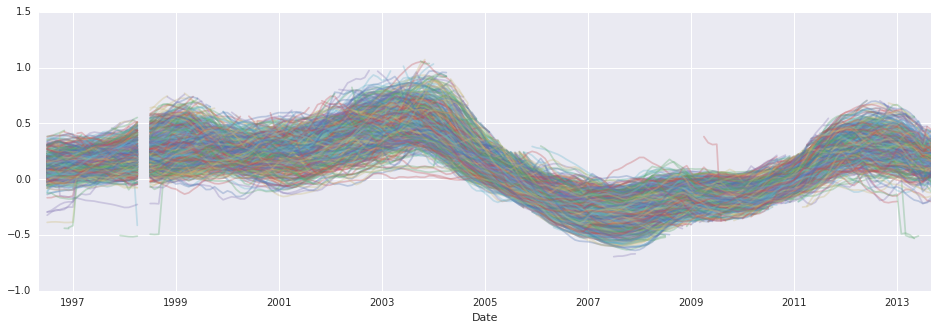

In [5]:
tar.plot(legend=False, alpha=.3, figsize=[16,5])

## increasing values

(224, 724) (0, 724)
int: -0.108473	coef: 0.004094	r2 score: 0.315671	xs corr: 0.242178


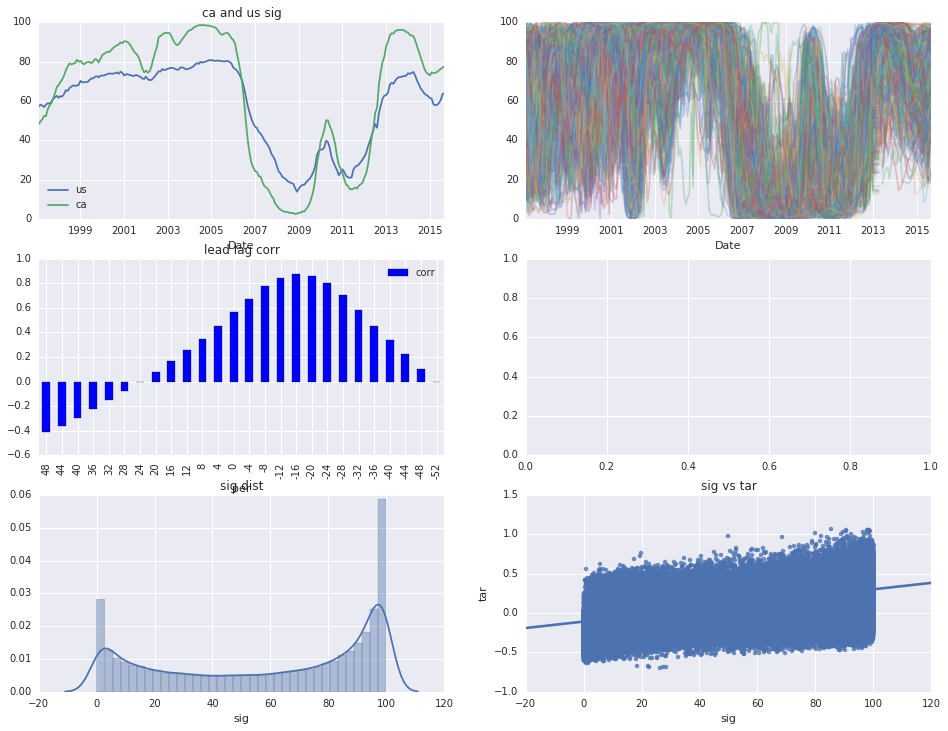

In [6]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## ratio sales price to list price

(77, 554) (0, 554)
int: -1.903726	coef: 2.051896	r2 score: 0.081310	xs corr: 0.326732


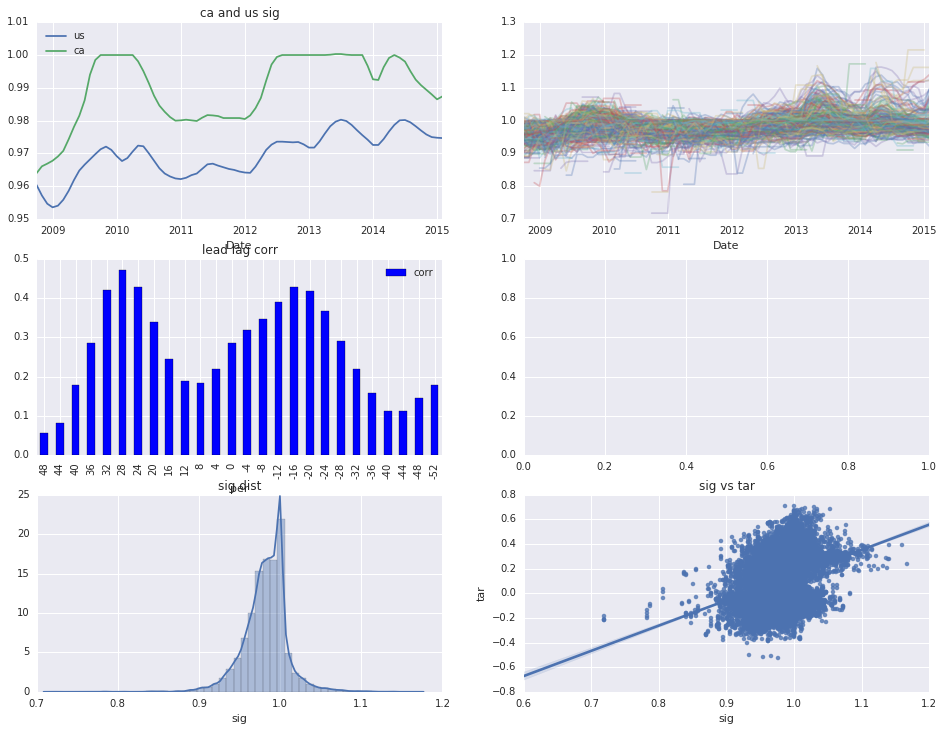

In [7]:
series = 'SLPR'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## turnover in housing market in past year

(213, 1115) (0, 1115)
int: 0.005296	coef: 0.022048	r2 score: 0.032310	xs corr: 0.063294


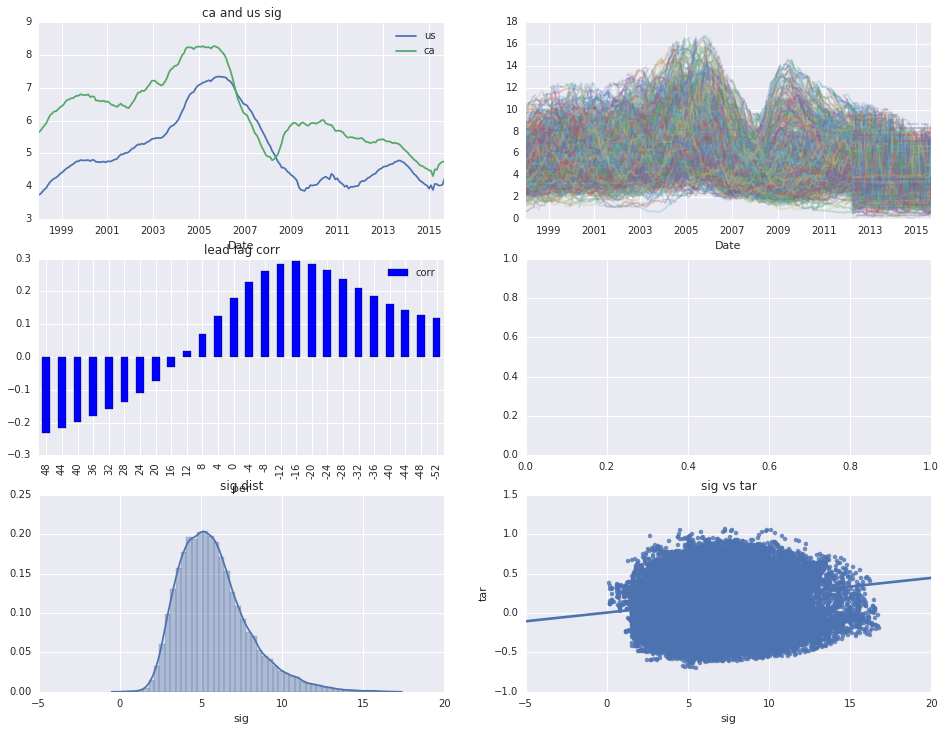

In [8]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

## sold for gain
- this seems to simply show that people who sold after the crisis got screwed, not sure if it adds any predictive power

(213, 713) (9, 713)
int: -0.163917	coef: 0.003505	r2 score: 0.042228	xs corr: 0.048023


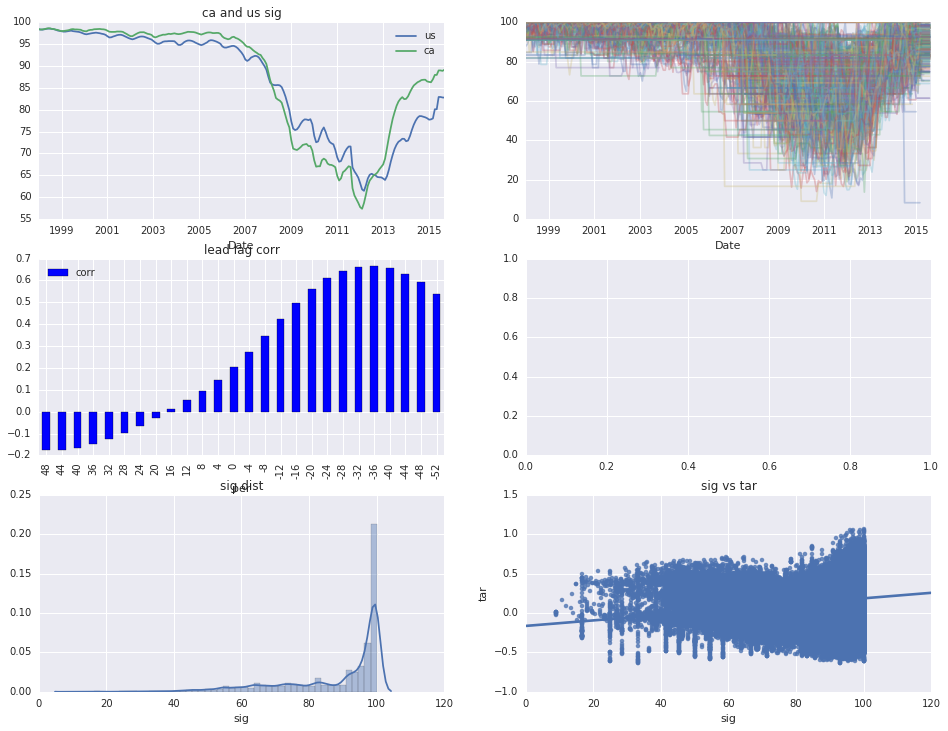

In [9]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

(61, 977) (0, 977)
int: 0.277967	coef: -0.012862	r2 score: 0.102780	xs corr: -0.284890


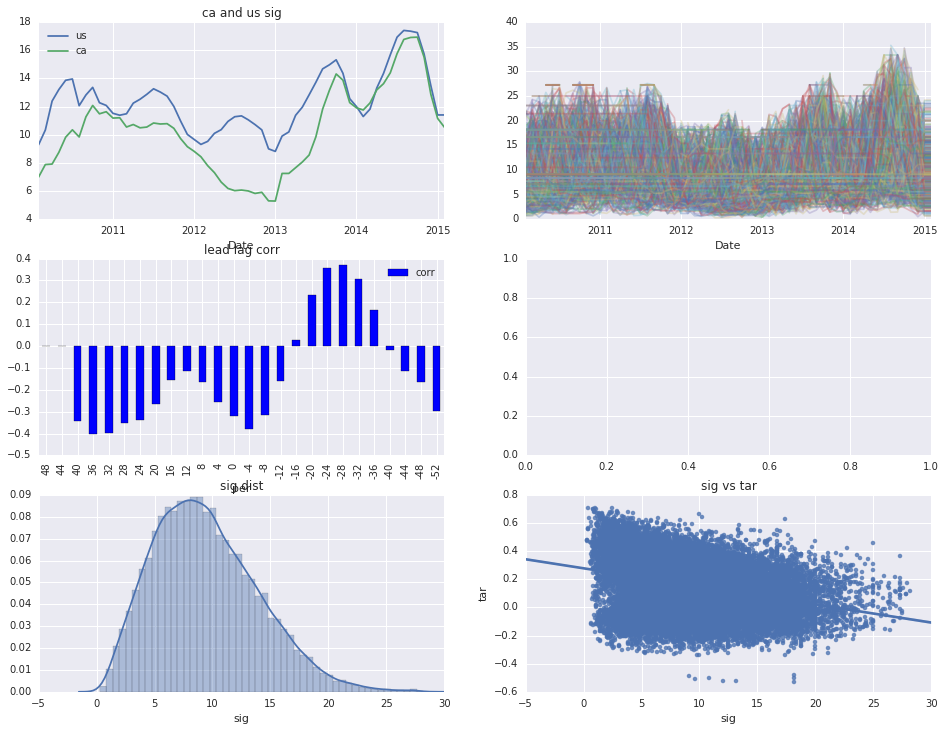

In [10]:
series = 'LPC'
px, px_ca, px_us = ql.load_series(series)
px = ut.xs_winsorize(px)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)
features[series] = px

# price per square foot
- this seems to be just another measure of housing prices, not additive

In [11]:
# series = 'MVSF'
# px, px_ca, px_us = ql.load_series(series)
# #px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
# px = ut.xs_winsorize(px)
# print(px.shape, px.dropna().shape)

# MVSF_c = px
# composite.explore_series(px, px_ca, px_us, tar)

# momentum
- seems like bad feature

In [162]:
def momentum(df, per=12):
    df = df.pct_change(fill_method=None)
    #return pd.rolling_mean(df, window=per).dropna()
    return pd.ewma(df, halflife=per, min_periods=per/2).dropna(how='all')

(228, 741) (0, 741)
int: 0.111917	coef: 4.305488	r2 score: 0.058499	xs corr: 0.113656


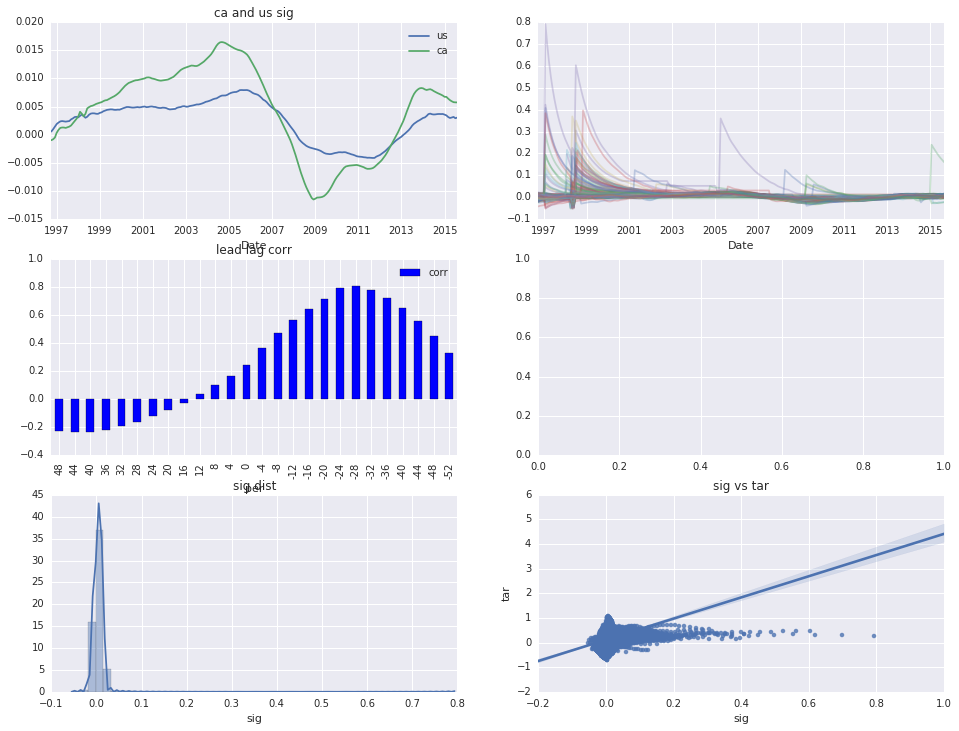

In [163]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px = ut.xs_winsorize(px).dropna()
px, px_ca, px_us = ut.capped_transformation(momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom = px
composite.explore_series(px, px_ca, px_us, tar)

# change in momentum
- seems like a bad feature

In [164]:
def momentum_change(df):
    mom_cur = momentum(df)
    mom_prev = momentum(df.shift(12))
    return (mom_cur - mom_prev).dropna(how='all')

(216, 741) (0, 741)
int: 0.131789	coef: 6.167371	r2 score: 0.070621	xs corr: 0.249910


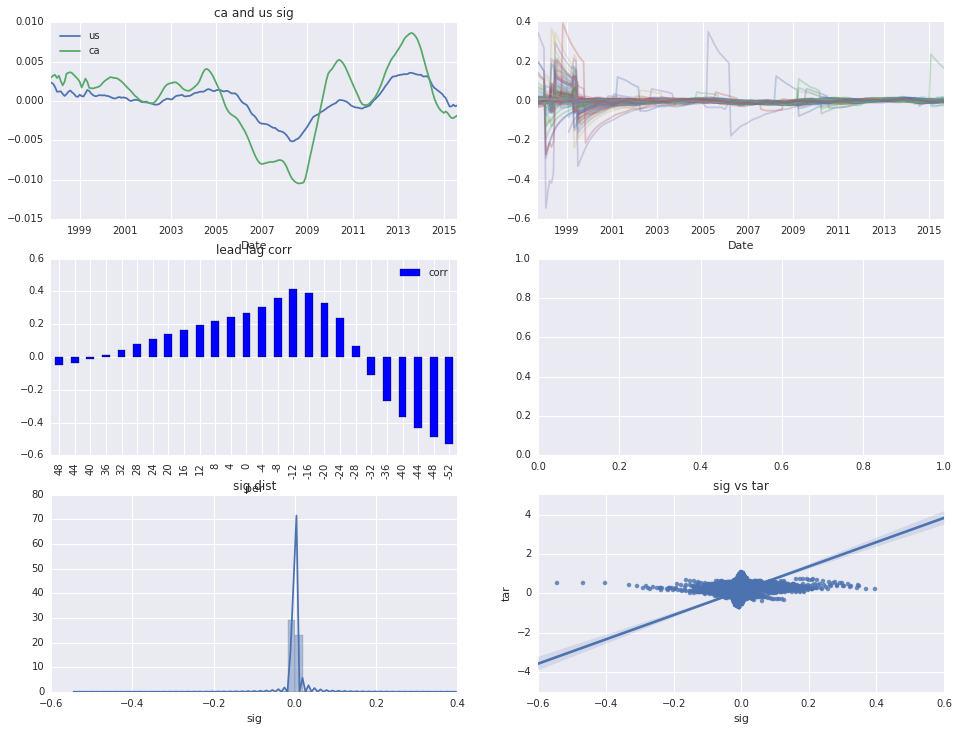

In [165]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px = ut.xs_winsorize(px).dropna()
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom_chg = px
composite.explore_series(px, px_ca, px_us, tar)

## prep data

In [156]:
df = ut.stack_and_align(features.values(), cols=features.keys())#.dropna()
df.index.levels[1].name = 'code'
for c in df.columns:
    print("{0}\t{1}".format(c, df[c].unstack().dropna(how='all').shape))

LPC	(61, 1120)
tar	(205, 1120)
SPY	(213, 1120)
SLPR	(77, 1120)
IV	(224, 1120)


In [157]:
def gen_mkt_movement(df):
    px, px_ca, px_us = ql.load_series(TARGET_SERIES)

    def expand_series_change(s, per):
        s = s.div(s.shift(per))
        return pd.DataFrame(np.repeat(np.array([s.values]).T, repeats=df.ix[:,0].unstack().shape[1], axis=1),
                            columns=df.ix[:,0].unstack().columns,
                            index=s.index)
    
    short = expand_series_change(px_ca, 6)
    med = expand_series_change(px_ca, 12)
    long = expand_series_change(px_ca, 24)
    
    mkt = ut.stack_and_align([short, med, long], cols=['short', 'med', 'long'])
    return mkt.ix[df.index]

mkt = gen_mkt_movement(df)

df = df.merge(mkt, left_index=True, right_index=True)

In [81]:
# def drop_crisis(df):
#     return (df[:datetime.datetime(2005,1,1)]
#             .append(df[datetime.datetime(2009,1,1):]))

# df = drop_crisis(df)

In [91]:
df.to_csv('data/processed/raw_grouped.csv')
df = df.dropna()

In [159]:
df.head()

LPC       tar  SPY  SLPR  IV  short  med  long
Date       code                                                 
1996-07-31 00002  NaN  0.128452  NaN   NaN NaN    NaN  NaN   NaN
           00007  NaN  0.151515  NaN   NaN NaN    NaN  NaN   NaN
           00008  NaN  0.298269  NaN   NaN NaN    NaN  NaN   NaN
           00010  NaN  0.253272  NaN   NaN NaN    NaN  NaN   NaN
           00026  NaN -0.010078  NaN   NaN NaN    NaN  NaN   NaN

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


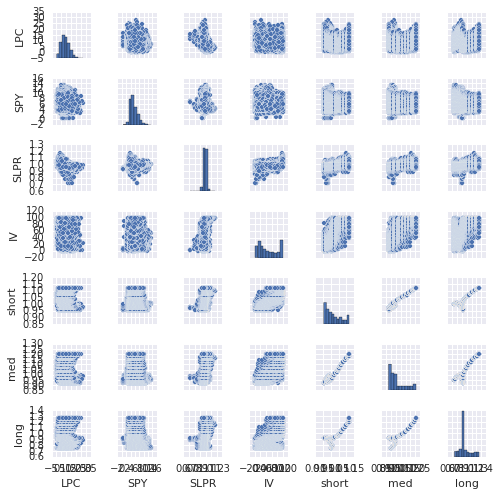

In [16]:
sns.pairplot(df[[c for c in df.columns if c != 'tar']], size=1)

In [60]:
df_ts = ut.ts_score(df, PANEL_SCORE).dropna(how='all')
df_ts.head()

LPC       tar       SPY      SLPR        IV     short  \
Date       code                                                                
2012-10-31 07541  0.466615  0.286477  0.062094 -1.754113  0.000072  2.131095   
           09374 -0.391599 -0.292875 -0.360936 -0.316552  1.792618  2.130603   
           09465 -1.027005  0.891901  2.225723  0.888615  1.558697  2.130111   
           09895 -0.178154  0.348567 -0.455074 -1.051123 -0.009709  2.129620   
2012-11-30 00002 -0.706317  0.658760 -0.237964  0.797512  2.079686  2.329944   

                       med      long  
Date       code                       
2012-10-31 07541  2.385518  1.590728  
           09374  2.384853  1.590494  
           09465  2.384189  1.590260  
           09895  2.383525  1.590026  
2012-11-30 00002  2.705927  1.894957

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


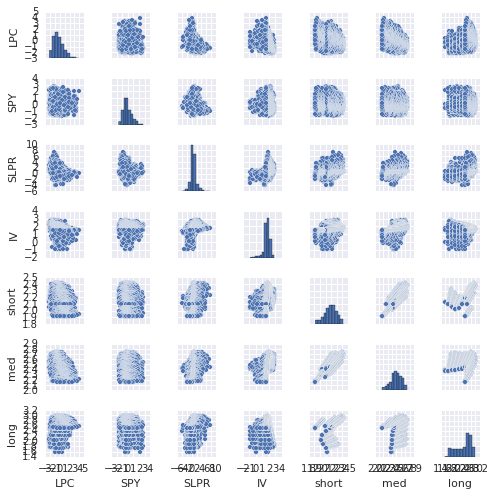

In [18]:
sns.pairplot(df_ts[[c for c in df_ts.columns if c != 'tar']], size=1)

In [61]:
print(df[df_ts.iloc[0].name[0]:df_ts.iloc[-1].name[0]].shape)
print(df_ts.shape)

(4988, 8)
(4560, 8)


In [62]:
df_r = ut.xs_rank_features(df)
df_r.head()

LPC       tar       SPY      SLPR        IV     short  \
Date       code                                                                
2010-02-28 00002  0.628895  0.424929  0.549575  0.441926  0.512748  1.001762   
           00007  0.575071  0.507082  0.541076  0.464589  0.781870  1.001762   
           00008  0.320113  0.804533  0.594901  0.682720  0.660057  1.001762   
           00010  0.300283  0.781870  0.288952  0.498584  0.609065  1.001762   
           00026  0.470255  0.087819  0.764873  0.532578  0.237960  1.001762   

                       med      long  
Date       code                       
2010-02-28 00002  0.953605  0.751376  
           00007  0.953605  0.751376  
           00008  0.953605  0.751376  
           00010  0.953605  0.751376  
           00026  0.953605  0.751376

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


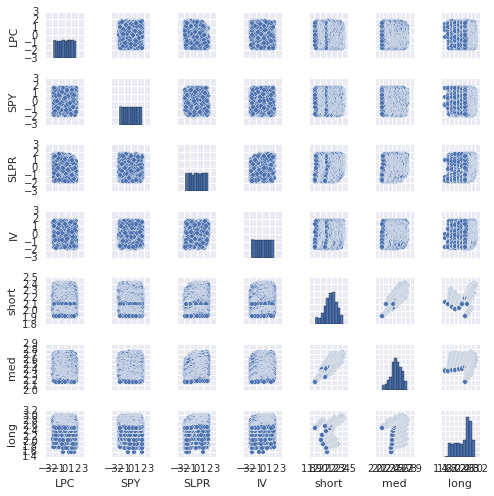

In [36]:
sns.pairplot(df_ts[[c for c in df_ts.columns if c != 'tar']], size=1)

## upper bound



sharpe ratios:
0.2    1.367129
0.4    3.297025
0.6    4.086157
0.8    4.762644
1.0    5.808380
mkt    3.905100
dtype: float64


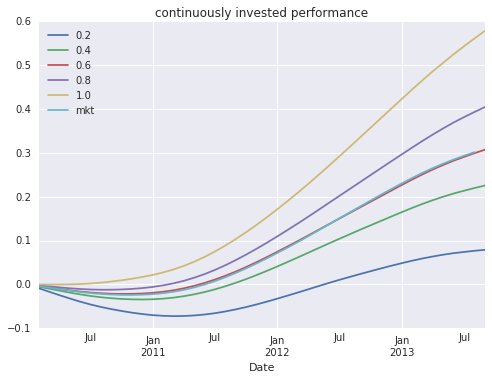

In [20]:
ret = ql.load_returns().stack().ix[df.index]    
df_res = ut.stack_and_align([df['tar'], ret], cols=('pred', 'ret'))
q = ut.gen_quintile_ts(df_res, 'pred', 'ret', agg='mean')
q['mkt'] = ql.load_returns('states').ix[:,0]
print('\n')
print('sharpe ratios:')
print(ut.get_sharpe_ratio(q))
ut.get_cum_perforance(q).plot(title='continuously invested performance')



sharpe ratios:
0.2     9.891357
0.4    13.809017
0.6    17.155583
0.8    20.111774
1.0    23.436540
mkt    16.252970
dtype: float64


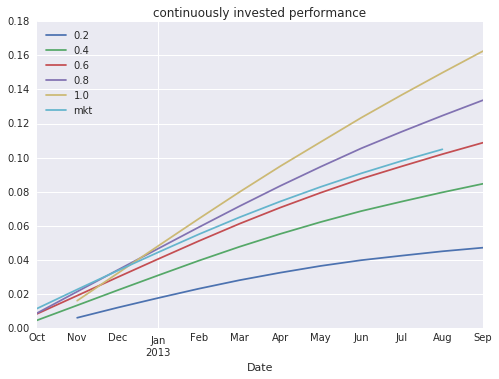

In [21]:
ret = ql.load_returns().stack().ix[df_ts.index]    
df_res = ut.stack_and_align([df_ts['tar'], ret], cols=('pred', 'ret'))
q = ut.gen_quintile_ts(df_res, 'pred', 'ret', agg='mean')
q['mkt'] = ql.load_returns('states').ix[:,0]
print('\n')
print('sharpe ratios:')
print(ut.get_sharpe_ratio(q))
ut.get_cum_perforance(q).plot(title='continuously invested performance')

##fit models

In [45]:
import imp
imp.reload(composite)
imp.reload(ut)

<module 'utils.utils' from '/home/condauser/notebooks/utils/utils.py'>

straw man (vanilla regression)

r2: 0.491243	xs corr: 0.604426


sharpe ratios:
0.2    14.282387
0.4    18.698772
0.6    18.063817
0.8    13.301170
1.0    20.813634
mkt    16.252970
dtype: float64


int: 0.555849	coef: [-0.21263953  0.28759819  0.18493719 -0.11065401 -0.63246539  0.92839414
 -0.45906725]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


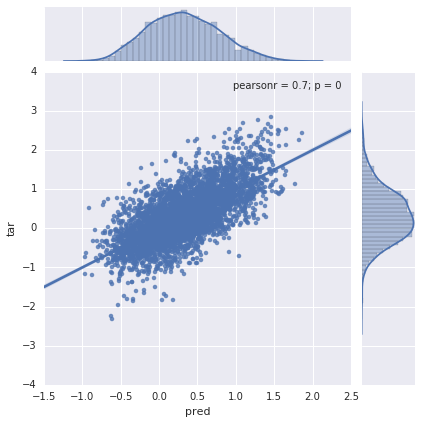

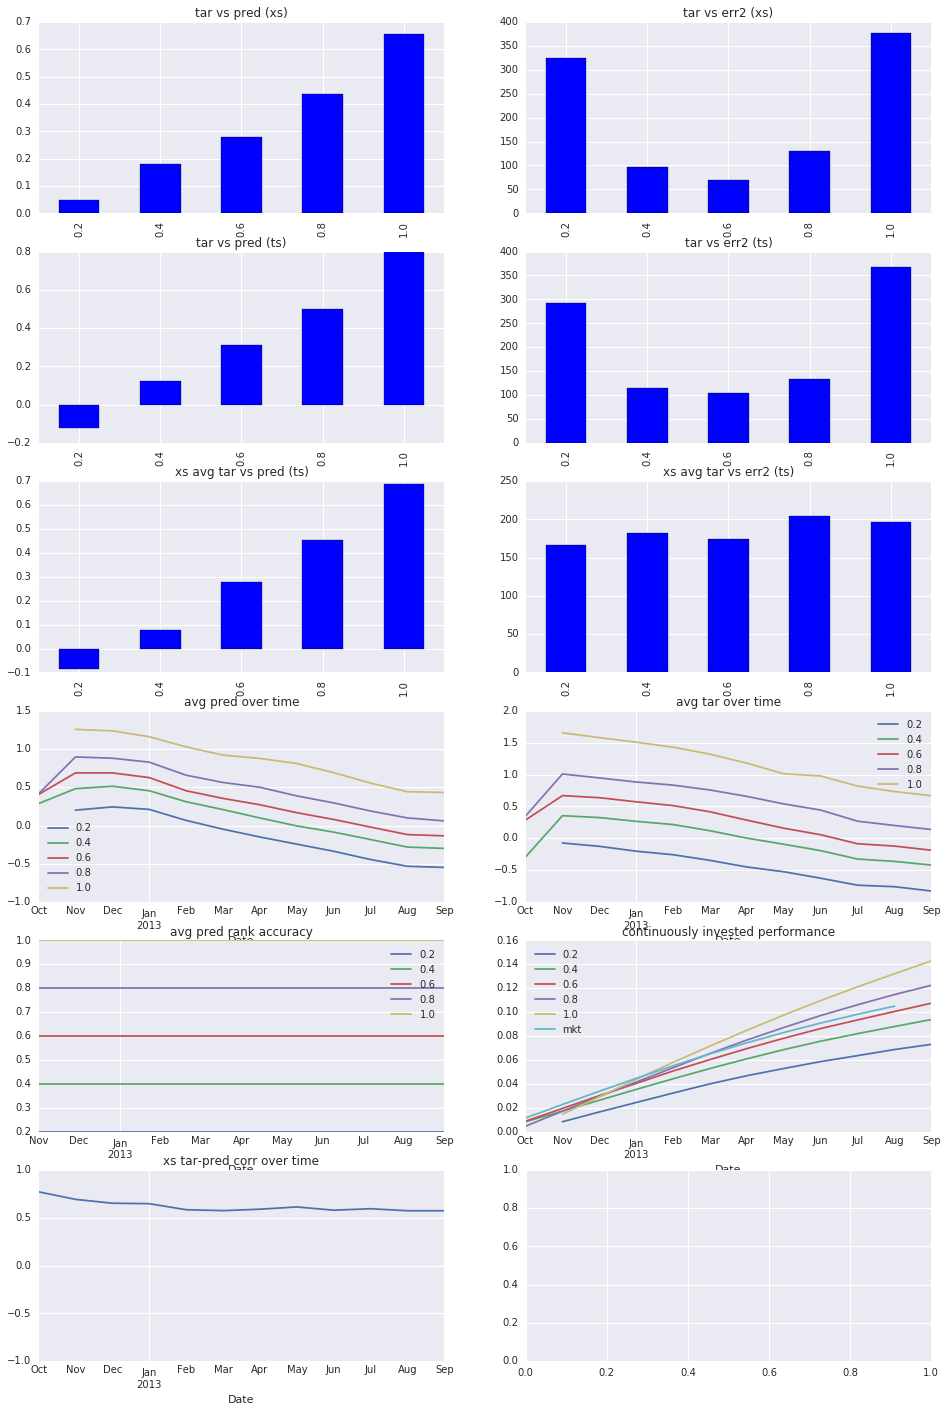

In [23]:
clf = lm.LinearRegression()
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')
res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [ ]:
a_range = res[0].iloc[0].name[0], res[0].iloc[-1].name[0]
a_index = res[0].index

In [ ]:
pred = composite.rolling_fit(clf, df_ts)
res = composite.model_empirics(clf, df_ts.ix[pred.index], pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [ ]:
b_range = res[0].iloc[0].name[0], res[0].iloc[-1].name[0]
b_index = res[0].index

In [117]:
print(a_range)
print(b_range)

(Timestamp('1999-10-31 00:00:00'), Timestamp('2013-09-30 00:00:00'))
(Timestamp('2002-10-31 00:00:00'), Timestamp('2013-09-30 00:00:00'))


ml models



r2: 0.440197	xs corr: 0.268725


sharpe ratios:
0.2    1.052293
0.4    1.660585
0.6    1.961956
0.8    2.195393
1.0    2.283719
mkt    1.837238
dtype: float64


int: -0.000000	coef: [ 0.06834183 -0.03463307  0.14010571 -0.07342094 -0.02297924  0.55686932
  0.08107634 -0.24059927]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


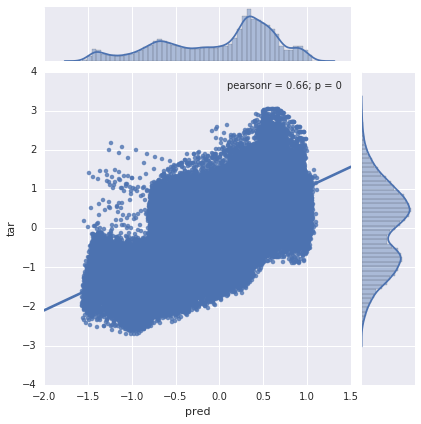

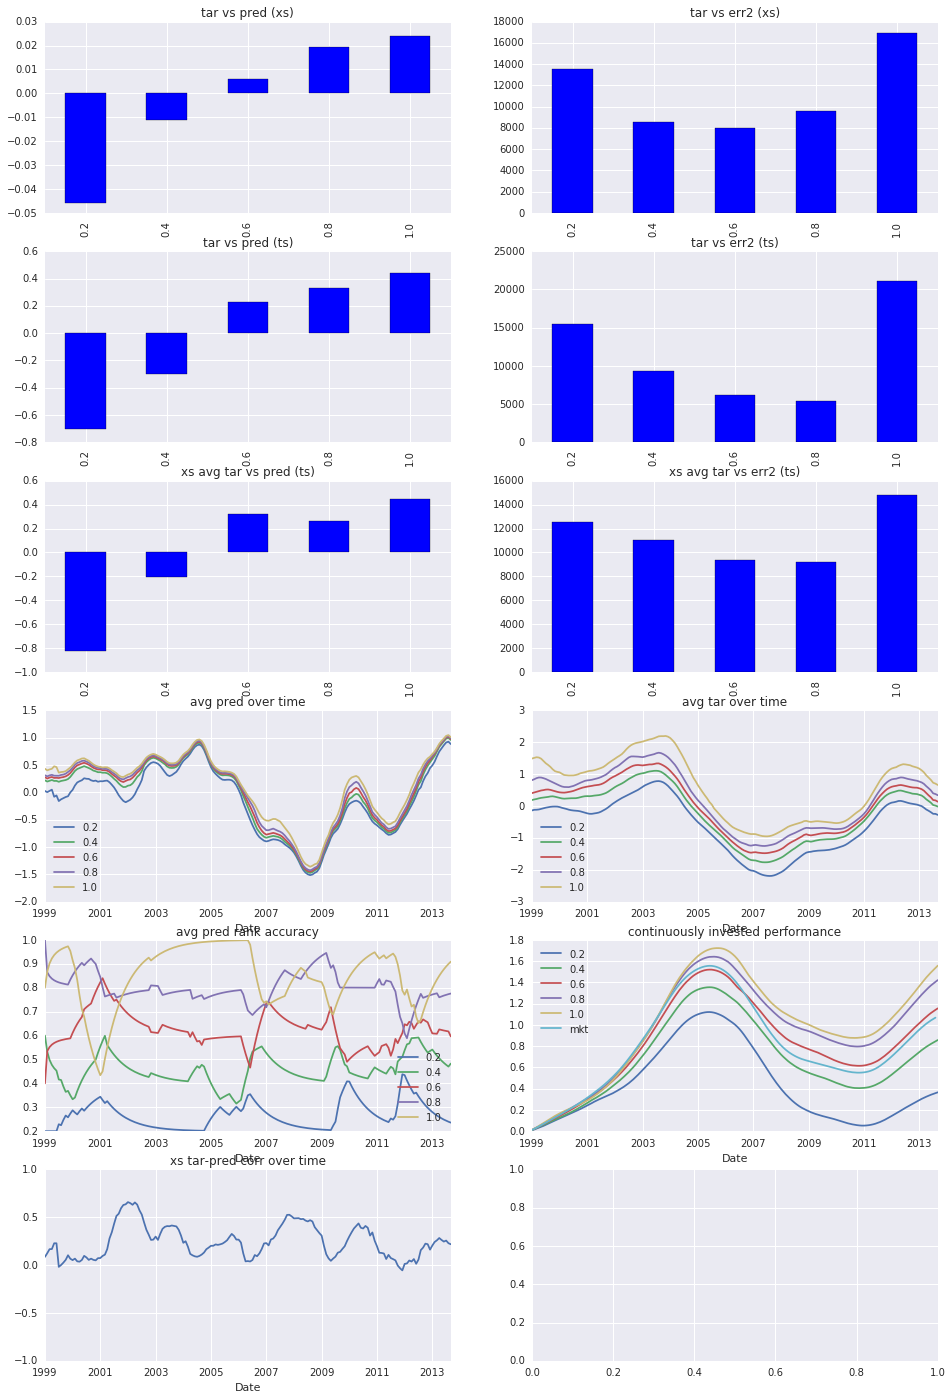

In [61]:
clf = lm.Ridge(alpha=5000)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')
res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [26]:
clf = GridSearchCV(lm.Ridge(), 
                   param_grid={'alpha': [1., 10., 100, 1000, 10000, 50000, 10000000]}, 
                   cv=5, iid=False)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')

# res = composite.model_empirics(clf, df_ts, pred)
# print('\n')
# print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

[mean: -4.43704, std: 1.87222, params: {'alpha': 1.0},
 mean: -4.41876, std: 1.86114, params: {'alpha': 10.0},
 mean: -4.26905, std: 1.77079, params: {'alpha': 100},
 mean: -3.69715, std: 1.41516, params: {'alpha': 1000},
 mean: -2.73244, std: 0.91773, params: {'alpha': 10000},
 mean: -2.24987, std: 0.96047, params: {'alpha': 50000},
 mean: -3.79058, std: 2.68568, params: {'alpha': 10000000}]


Ridge(alpha=50000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)




r2: 0.107805	xs corr: 0.228741


sharpe ratios:
0.2    0.566309
0.4    1.100585
0.6    1.353112
0.8    1.528008
1.0    1.519567
mkt    1.153434
dtype: float64


int: 0.012679	coef: [ 0.09178156 -0.02119535  0.11718011 -0.11177479 -0.01983533  0.23232654
  0.12209329 -0.02341312]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


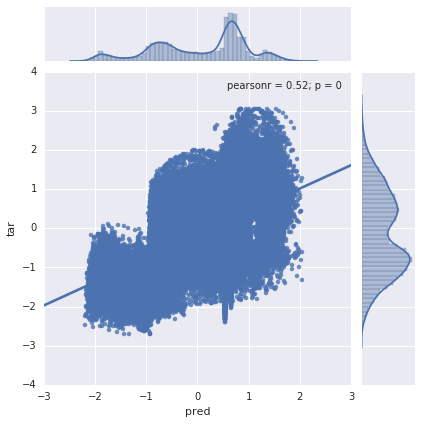

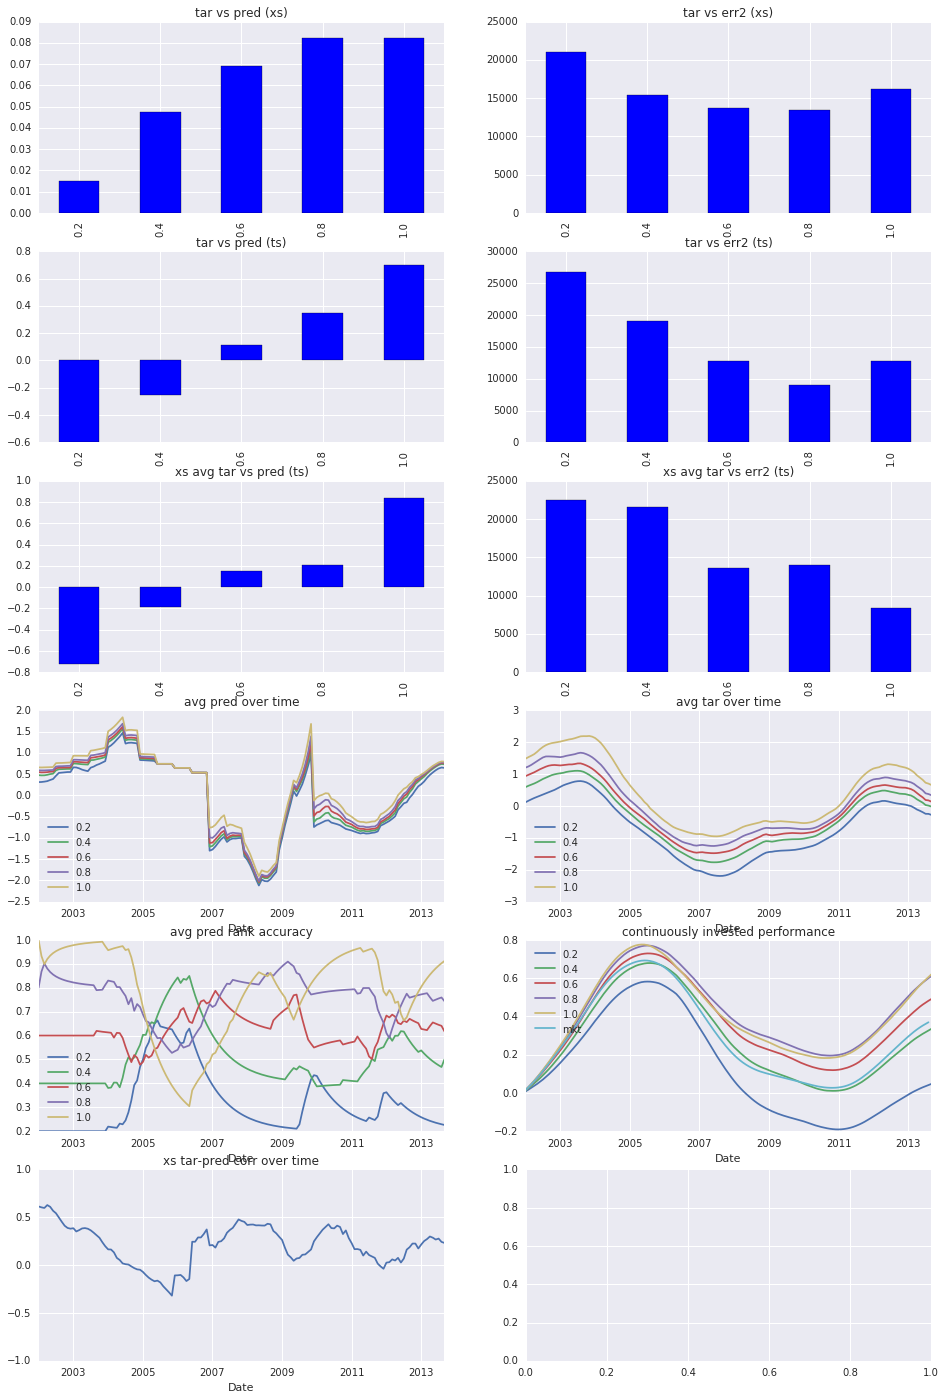

In [53]:
pred = composite.rolling_fit(clf, df_ts)
res = composite.model_empirics(clf, df_ts.ix[pred.index], pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

lasso model

/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[mean: -4.41798, std: 1.85926, params: {'alpha': 0.0001},
 mean: -4.24269, std: 1.73813, params: {'alpha': 0.001},
 mean: -3.42048, std: 1.32805, params: {'alpha': 0.01},
 mean: -2.17337, std: 1.19156, params: {'alpha': 0.1}]


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


r2: 0.400380	xs corr: 0.283549


sharpe ratios:
0.2    1.049194
0.4    1.635928
0.6    1.960771
0.8    2.153254
1.0    2.309174
mkt    1.837238
dtype: float64


int: -0.000000	coef: [ 0.03169041 -0.         -0.          0.01321013 -0.          0.51507561
  0.         -0.        ]


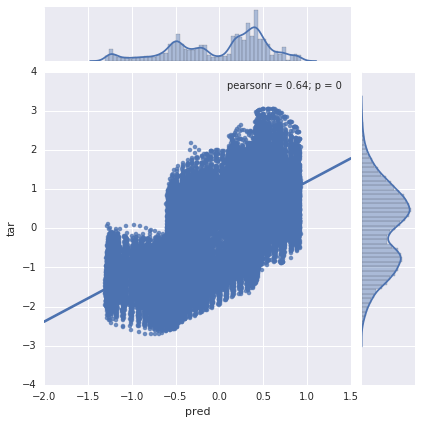

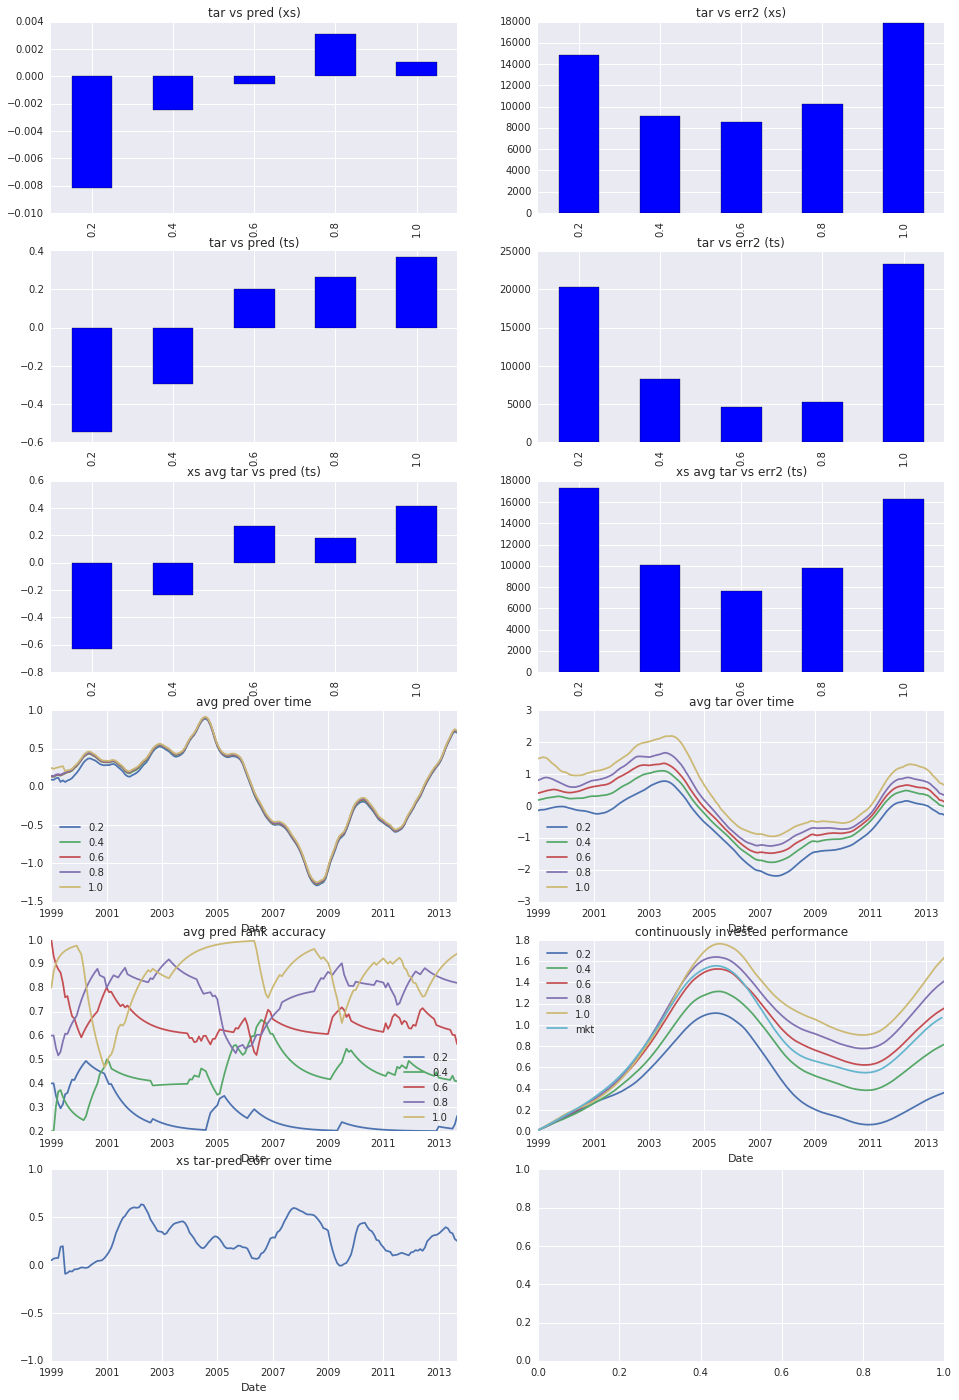

In [39]:
clf = GridSearchCV(lm.Lasso(), 
                   param_grid={'alpha': [.0001, .001, .01, .1]}, 
                   cv=5, iid=False)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')

res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

random forest

[mean: -5.75266, std: 7.44504, params: {'max_depth': 2, 'max_features': None},
 mean: -4.79127, std: 6.54111, params: {'max_depth': 2, 'max_features': 1},
 mean: -4.77499, std: 6.01672, params: {'max_depth': 2, 'max_features': 2},
 mean: -2.89736, std: 2.93814, params: {'max_depth': 5, 'max_features': None},
 mean: -3.82384, std: 4.75711, params: {'max_depth': 5, 'max_features': 1},
 mean: -4.43932, std: 5.69973, params: {'max_depth': 5, 'max_features': 2}]


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=50, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)
r2: 0.789694	xs corr: 0.523622


sharpe ratios:
0.2    2.483106
0.4    3.701950
0.6    4.076755
0.8    4.494024
1.0    4.871127
mkt    3.905100
dtype: float64


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


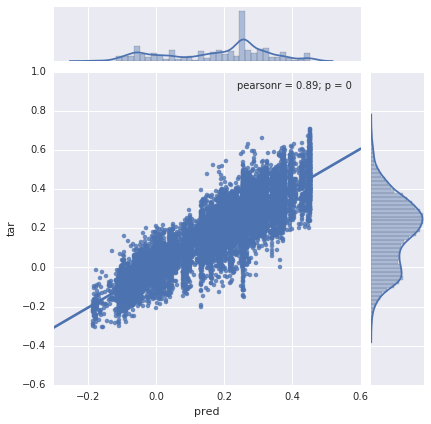

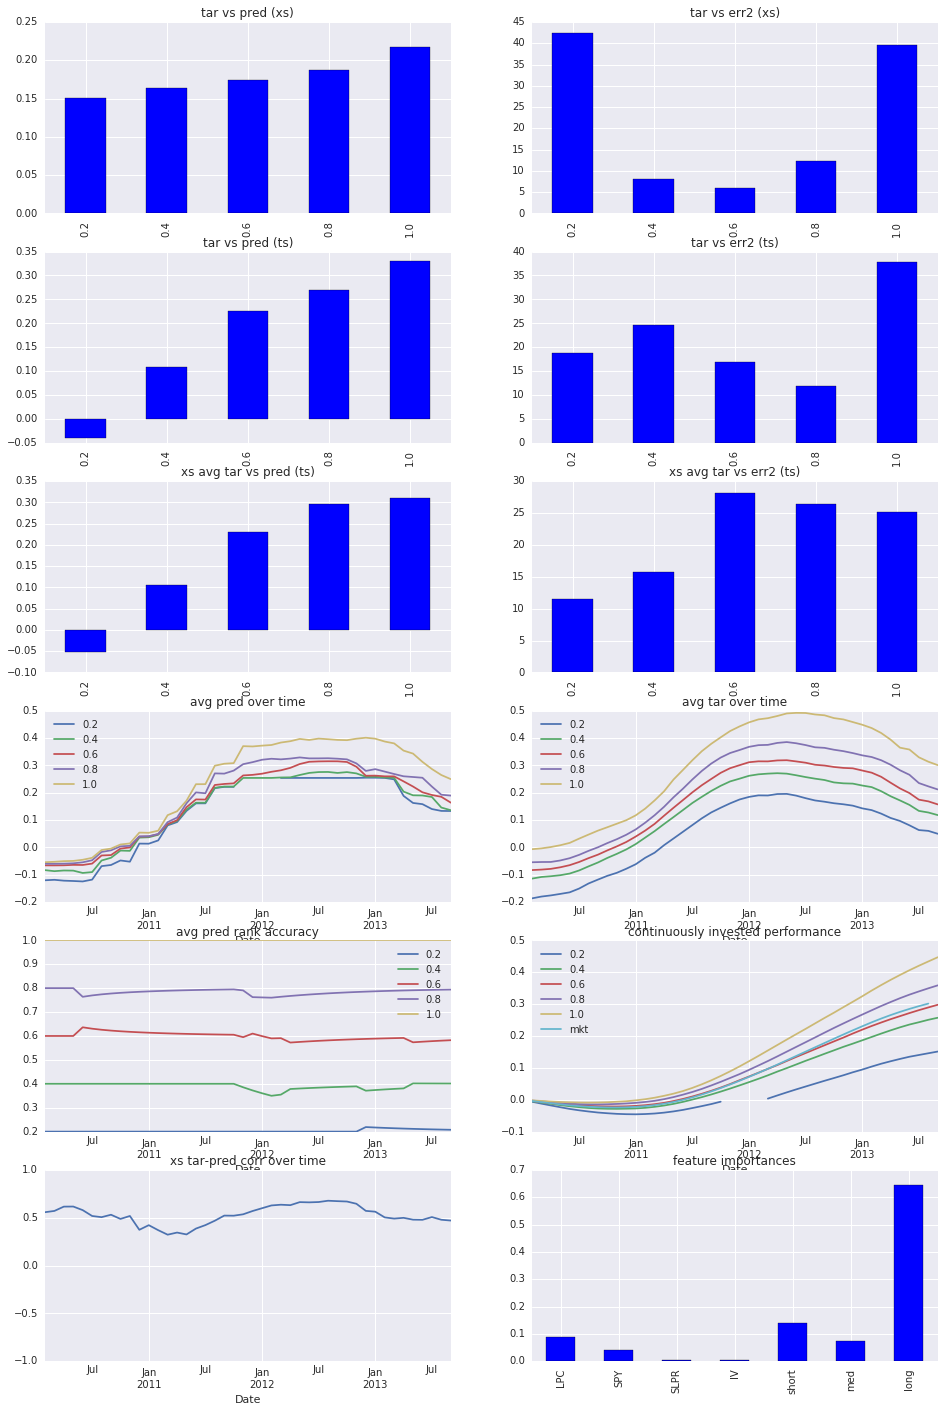

In [66]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=50), 
                   param_grid={'max_depth': [2,5,], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf.fit(df[[c for c in df.columns if c != 'tar']], df['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df[[c for c in df.columns if c != 'tar']]), 
                 index=df.index, name='pred')

res = composite.model_empirics(clf, df, pred)

(pd.Series(clf.best_estimator_.feature_importances_, 
           index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

2010-02-28 00:00:00	2011-01-31 00:00:00	2011-02-28 00:00:00	2011-07-31 00:00:00
2010-02-28 00:00:00	2011-07-31 00:00:00	2011-08-31 00:00:00	2012-01-31 00:00:00
2010-02-28 00:00:00	2012-01-31 00:00:00	2012-02-29 00:00:00	2012-07-31 00:00:00
2010-02-28 00:00:00	2012-07-31 00:00:00	2012-08-31 00:00:00	2013-01-31 00:00:00
2010-02-28 00:00:00	2013-01-31 00:00:00	2013-02-28 00:00:00	2013-07-31 00:00:00
2010-02-28 00:00:00	2013-07-31 00:00:00	2013-08-31 00:00:00	2013-09-30 00:00:00
r2: -1.580271	xs corr: 0.472296


sharpe ratios:
0.2     9.630149
0.4    10.825522
0.6    11.062997
0.8    11.366053
1.0    11.974224
mkt    10.962804
dtype: float64


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


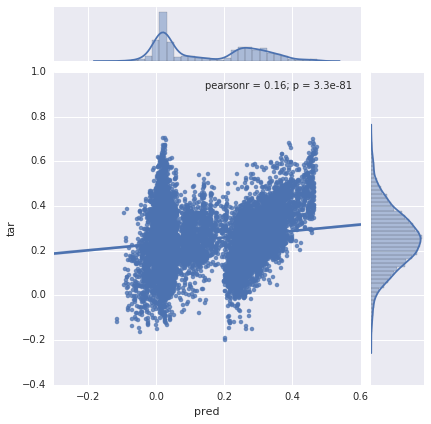

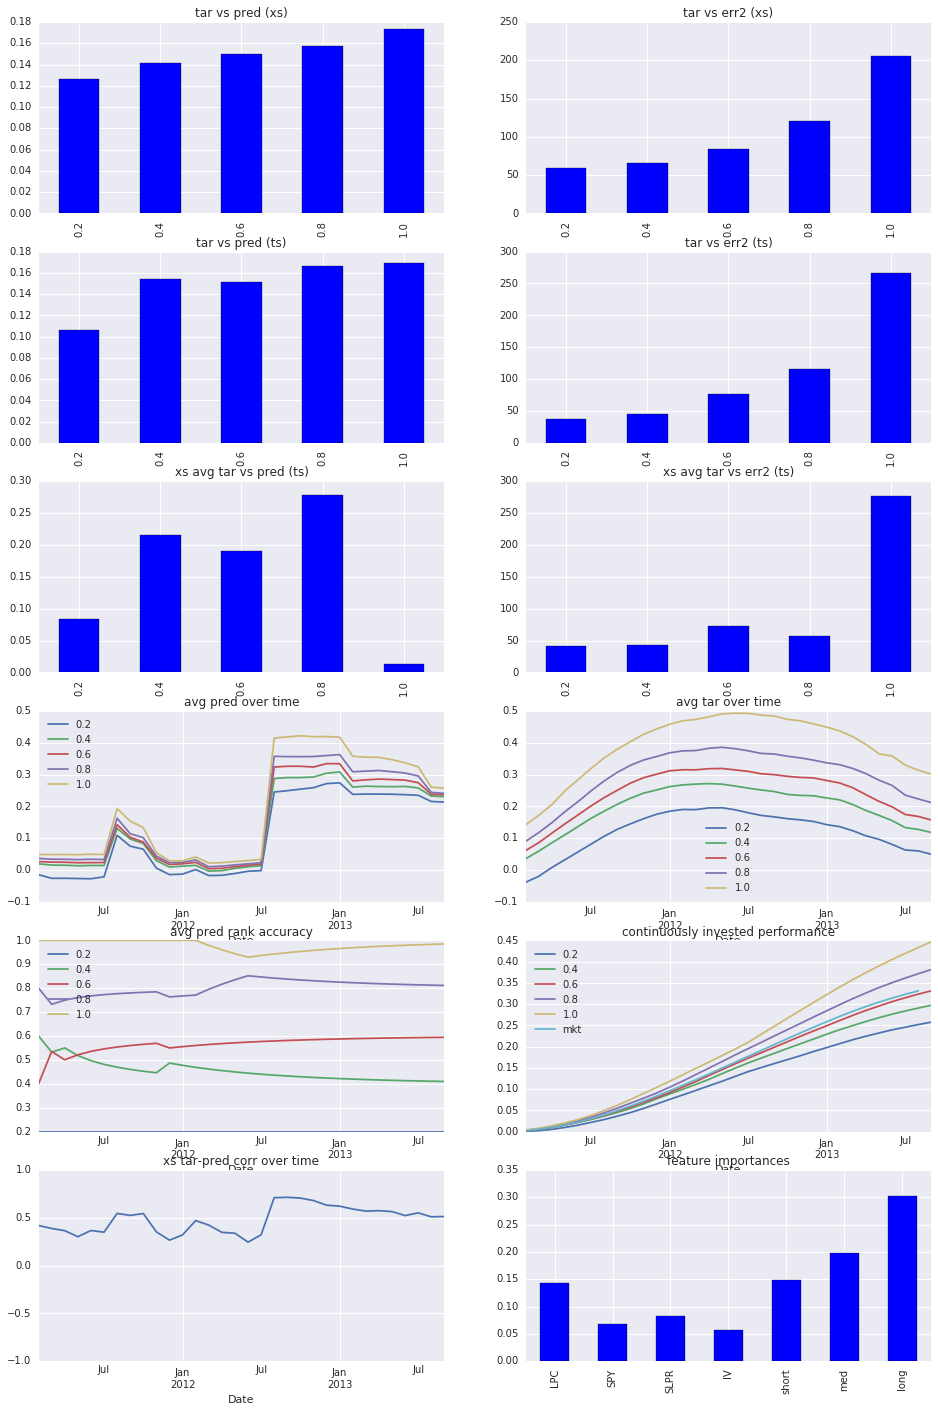

In [67]:
pred = composite.rolling_fit(clf, df)
res = composite.model_empirics(clf, df.ix[pred.index], pred)
(pd.Series(clf.best_estimator_.feature_importances_, 
           index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

random forest - ranked

[mean: 0.15625, std: 0.18847, params: {'max_depth': 5, 'max_features': None},
 mean: 0.19975, std: 0.09979, params: {'max_depth': 5, 'max_features': 1},
 mean: 0.21326, std: 0.12915, params: {'max_depth': 5, 'max_features': 2},
 mean: 0.16690, std: 0.21237, params: {'max_depth': 7, 'max_features': None},
 mean: 0.22874, std: 0.10777, params: {'max_depth': 7, 'max_features': 1},
 mean: 0.22515, std: 0.14989, params: {'max_depth': 7, 'max_features': 2},
 mean: 0.18543, std: 0.20670, params: {'max_depth': 9, 'max_features': None},
 mean: 0.24050, std: 0.11964, params: {'max_depth': 9, 'max_features': 1},
 mean: 0.24152, std: 0.15585, params: {'max_depth': 9, 'max_features': 2}]


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=9, max_features=2,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)
r2: 0

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


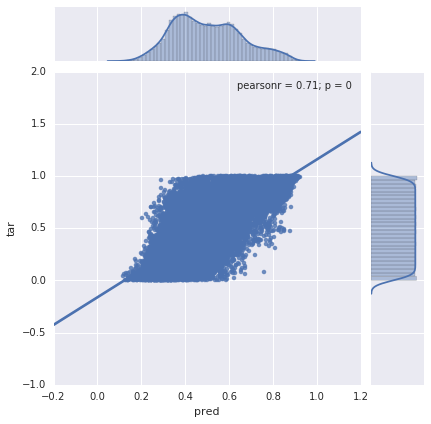

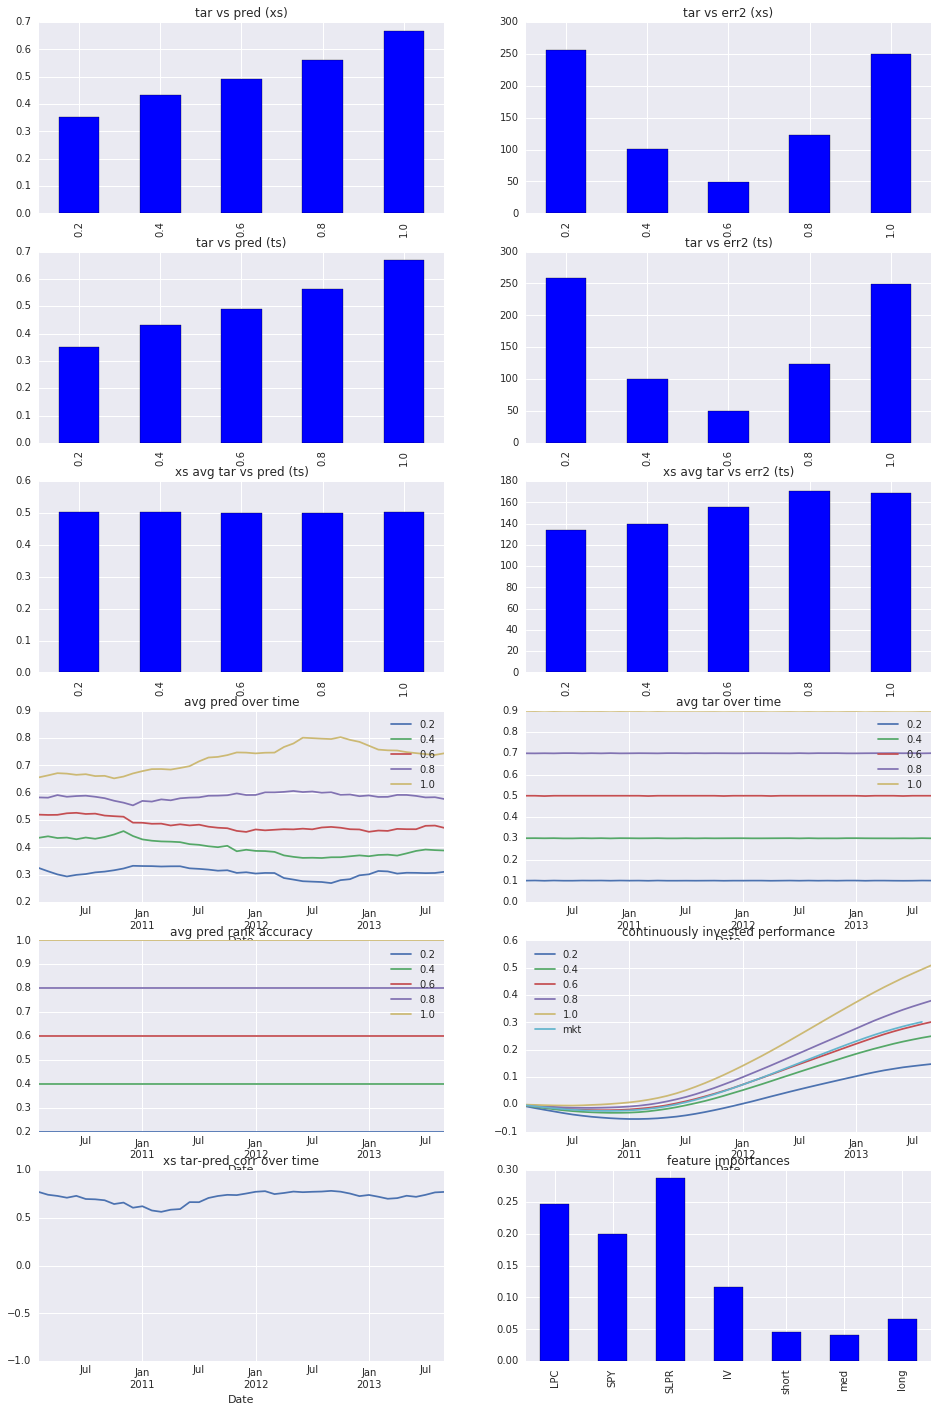

In [75]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), 
                   param_grid={'max_depth': [5,7,9], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf.fit(df_r[[c for c in df_r.columns if c != 'tar']], df_r['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_r[[c for c in df_r.columns if c != 'tar']]), 
                 index=df_r.index, name='pred')

res = composite.model_empirics(clf, df_r, pred)

(pd.Series(clf.best_estimator_.feature_importances_, 
           index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

2010-02-28 00:00:00	2011-01-31 00:00:00	2011-02-28 00:00:00	2011-07-31 00:00:00
2010-02-28 00:00:00	2011-07-31 00:00:00	2011-08-31 00:00:00	2012-01-31 00:00:00
2010-02-28 00:00:00	2012-01-31 00:00:00	2012-02-29 00:00:00	2012-07-31 00:00:00
2010-02-28 00:00:00	2012-07-31 00:00:00	2012-08-31 00:00:00	2013-01-31 00:00:00
2010-02-28 00:00:00	2013-01-31 00:00:00	2013-02-28 00:00:00	2013-07-31 00:00:00
2010-02-28 00:00:00	2013-07-31 00:00:00	2013-08-31 00:00:00	2013-09-30 00:00:00
r2: 0.282788	xs corr: 0.515266


sharpe ratios:
0.2     8.837895
0.4    10.756448
0.6    11.443936
0.8    12.184129
1.0    11.925813
mkt    10.962804
dtype: float64


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


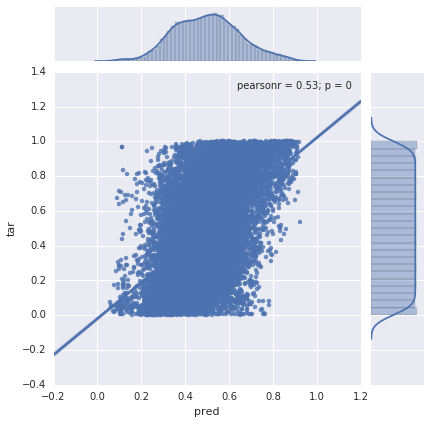

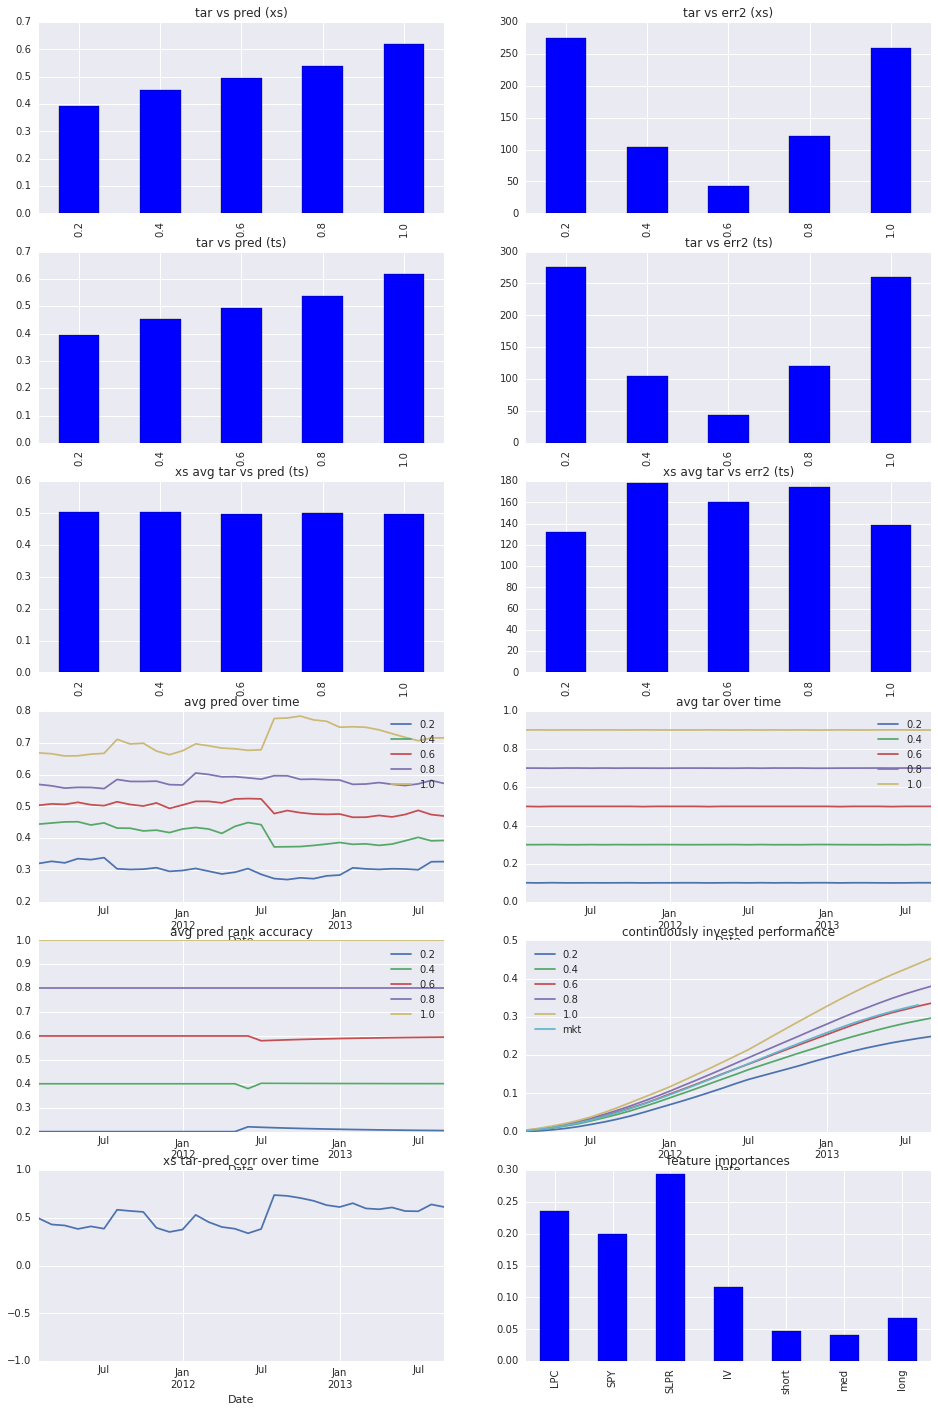

In [76]:
pred = composite.rolling_fit(clf, df_r)
res = composite.model_empirics(clf, df_r.ix[pred.index], pred)
(pd.Series(clf.best_estimator_.feature_importances_, 
           index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

gradient boosting

In [ ]:
# clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
#                                                             'max_depth': [1,3,5], 
#                                                             'max_features': [None, 1, 2]}, 
#                    cv=5, n_jobs=2, idd=False)
# clf, df_res, score, pred = composite.build_model(clf, df)

In [ ]:
# (pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
#  .plot(kind='bar', title='feature importances'))

full fit and forecast

In [77]:
clf

GridSearchCV(cv=5,
       estimator=RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0),
       fit_params={}, iid=False, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [5, 7, 9], 'max_features': [None, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [78]:
clf.fit(df_r[[c for c in df_r.columns if c != 'tar']], df_r['tar'])

GridSearchCV(cv=5,
       estimator=RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0),
       fit_params={}, iid=False, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [5, 7, 9], 'max_features': [None, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [169]:
df = pd.read_csv('data/processed/raw_grouped.csv', 
                 parse_dates=['Date',], 
                 converters={'code': str})
df = df.set_index(['Date', 'code'])
df = df[[c for c in df.columns if c != 'tar']].dropna()
df_r = ut.xs_rank_features(df)

In [170]:
latest = df_r.ix['2015-02-28':]
pred = pd.Series(clf.predict(latest), index=latest.index, name='pred')
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

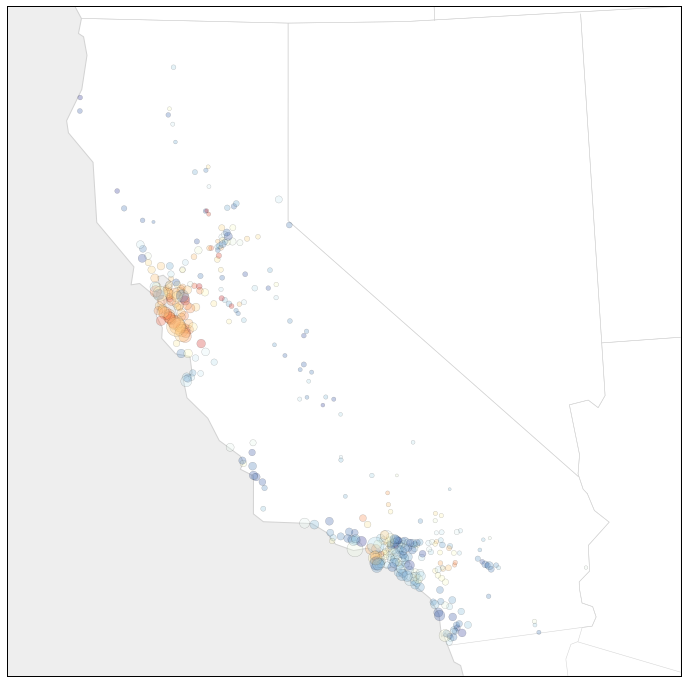

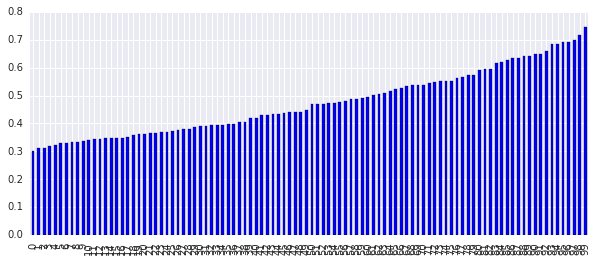

In [173]:
imp.reload(maps)
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .0001).values, c=row.pred.values * -1., **style)
plt.figure()
pd.Series(row.sample(n=100).pred.sort_values().values).plot(kind='bar', figsize=(10,4))

In [180]:
ranks = map_pred.sort_values('pred', ascending=False).reset_index()

In [181]:
ranks[ranks.city=='Fresno']

date   code      px      pred         lon        lat    city state  \
353 2015-02-28  00026  178400  0.355503 -119.772587  36.746842  Fresno    CA   

     region  county  
353  Fresno  Fresno